In [8]:
import os
import numpy as np
import cv2
from pycocotools.coco import COCO
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [13]:
coco_dir = './coco2017'
stanford_cars_dir = './stanford_cars'
annotations_path = os.path.join(coco_dir, 'annotations', 'instances_train2017.json')
coco = COCO(annotations_path)


loading annotations into memory...
Done (t=16.21s)
creating index...
index created!


In [14]:
car_ids = coco.getCatIds(catNms=['car'])
car_img_ids = coco.getImgIds(catIds=car_ids)

In [15]:
def preprocess_image(image_id, target_size=(224, 224)):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(coco_dir, './train2017', image_info['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id, catIds=car_ids))
    color_label = [0, 0, 0]  # One-hot encoding for colors (assuming 3 colors: red, blue, other)
    gender_label = [0, 0]  # One-hot encoding for gender (male, female)
    
    for ann in annotations:
        if 'color' in ann:
            if ann['color'] == 'red':
                color_label[1] = 1  # Swap red and blue
            elif ann['color'] == 'blue':
                color_label[0] = 1  # Swap blue and red
            else:
                color_label[2] = 1
        
        if 'gender' in ann:
            if ann['gender'] == 'male':
                gender_label[0] = 1
            else:
                gender_label[1] = 1

    return image, color_label, gender_label

In [16]:
# Preprocess all images
images = []
color_labels = []
gender_labels = []
for img_id in car_img_ids:
    img, color_label, gender_label = preprocess_image(img_id)
    images.append(img)
    color_labels.append(color_label)
    gender_labels.append(gender_label)

In [17]:
images = np.array(images)
color_labels = np.array(color_labels)
gender_labels = np.array(gender_labels)

In [18]:
print(f"Images shape: {images.shape}")
print(f"Color labels shape: {color_labels.shape}")
print(f"Gender labels shape: {gender_labels.shape}")

Images shape: (12251, 224, 224, 3)
Color labels shape: (12251, 3)
Gender labels shape: (12251, 2)


In [19]:
# Split the data into training and testing sets
train_images, test_images, train_color_labels, test_color_labels, train_gender_labels, test_gender_labels = train_test_split(
    images, color_labels, gender_labels, test_size=0.2, random_state=42
)

In [20]:
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train color labels shape: {train_color_labels.shape}")
print(f"Test color labels shape: {test_color_labels.shape}")
print(f"Train gender labels shape: {train_gender_labels.shape}")
print(f"Test gender labels shape: {test_gender_labels.shape}")

Train images shape: (9800, 224, 224, 3)
Test images shape: (2451, 224, 224, 3)
Train color labels shape: (9800, 3)
Test color labels shape: (2451, 3)
Train gender labels shape: (9800, 2)
Test gender labels shape: (2451, 2)


In [21]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
class MultiOutputDataGenerator(Sequence):
    def __init__(self, images, color_labels, gender_labels, batch_size, datagen, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.color_labels = color_labels
        self.gender_labels = gender_labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indices = np.arange(len(images))
        np.random.shuffle(self.indices)
    
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_color_labels = self.color_labels[batch_indices]
        batch_gender_labels = self.gender_labels[batch_indices]
        
        augmented_images = np.zeros((len(batch_images), *batch_images.shape[1:]))
        for i, img in enumerate(batch_images):
            augmented_images[i] = self.datagen.random_transform(img)
        
        return augmented_images, {'color_output': batch_color_labels, 'gender_output': batch_gender_labels}
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [23]:

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
# Example usage of the custom data generator
batch_size = 32
train_generator = MultiOutputDataGenerator(train_images, train_color_labels, train_gender_labels, batch_size, datagen)
test_generator = MultiOutputDataGenerator(test_images, test_color_labels, test_gender_labels, batch_size, datagen)


In [40]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [27]:
# Define the input tensor
input_tensor = Input(shape=(224, 224, 3))

In [29]:
# Define the CNN architecture with additional layers
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(1024, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)


In [30]:
# Adding custom layers for car color classification
color_output = Dense(3, activation='softmax', name='color_output')(x)  # Assuming 3 car colors

In [31]:
# Adding custom layers for gender classification
gender_output = Dense(2, activation='softmax', name='gender_output')(x)  # Male, Female

In [32]:
# Combine into a single multi-output model
model = Model(inputs=input_tensor, outputs=[color_output, gender_output])

In [33]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss={'color_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              metrics={'color_output': 'accuracy', 'gender_output': 'accuracy'})


In [35]:
# Train the model
model.fit(train_generator, 
          epochs=1, 
          validation_data=test_generator, 
          steps_per_epoch=len(train_generator), 
          validation_steps=len(test_generator))

307/307 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - color_output_accuracy: 0.3531 - gender_output_accuracy: 0.4961 - loss: 0.0000e+00 - val_color_output_accuracy: 0.0000e+00 - val_gender_output_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


In [36]:
# Save the model
model.save('traffic_signal_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


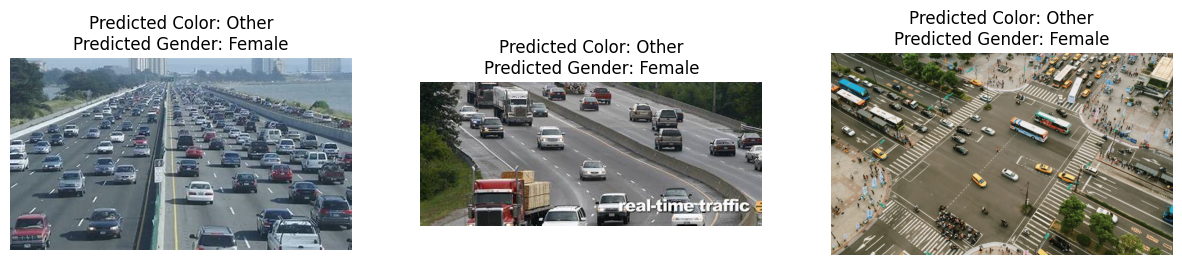

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder

# Load the trained model
model = load_model('traffic_signal_model.keras')

# Define a function to preprocess a single image for prediction
def preprocess_single_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = img_to_array(image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Sample testing with a few images
sample_image_paths = [
    './OIP (1).jpeg',
    './OIP.jpeg',
    './Traffic-Studies-Analysis-1.png'
]

color_labels = ['Blue', 'Red', 'Other']  # Assuming these are the color labels used
gender_labels = ['Male', 'Female']  # Assuming these are the gender labels used

# Define a function to decode one-hot encoded labels
def decode_labels(preds, color_labels, gender_labels):
    color_pred = np.argmax(preds[0], axis=1)
    gender_pred = np.argmax(preds[1], axis=1)
    return color_labels[color_pred[0]], gender_labels[gender_pred[0]]

# Plot the sample images with predictions
plt.figure(figsize=(15, 5))

for i, image_path in enumerate(sample_image_paths):
    preprocessed_image = preprocess_single_image(image_path)
    preds = model.predict(preprocessed_image)
    pred_color, pred_gender = decode_labels(preds, color_labels, gender_labels)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, len(sample_image_paths), i + 1)
    plt.imshow(image)
    plt.title(f"Predicted Color: {pred_color}\nPredicted Gender: {pred_gender}")
    plt.axis('off')

plt.show()
